# Demo de implementación de un algoritmo de Programación Genética para obtener un procedimiento que ordene una lista de valores numeéricos Utiliza la librería DEAP disponible en https://deap.readthedocs.io/en/master/

0) Preparar el ambiente:

In [1]:
#@title

# instala paquetes DEAP
!pip install deap

# instala paquetes gráficos
!apt-get install -y graphviz-dev
!pip install pygraphviz

Reading package lists... Done
Building dependency tree       
Reading state information... Done
Note, selecting 'libgraphviz-dev' instead of 'graphviz-dev'
libgraphviz-dev is already the newest version (2.40.1-2).
0 upgraded, 0 newly installed, 0 to remove and 14 not upgraded.


1) Importar librerías:

In [2]:
#@title
import random
import numpy as np

import operator
import math

from deap import algorithms
from deap import base
from deap import creator
from deap import tools
from deap import gp

import random
import copy

import matplotlib.pyplot as plt
import pygraphviz as pgv
from IPython.display import display
import tempfile
from PIL import Image
#import networkx as nx

print("\nLibrerías importadas")


Librerías importadas


2) Definir las listas que se van a ordenar:

In [3]:
#@title Generar los Datos de las Listas en forma aletatoria
Cantidad_Listas = 5 #@param {type:"slider", min:1, max:10, step:1}
Cantidad_Maxima_Elementos_Listas = 10 #@param {type:"slider", min:2, max:100, step:1}
Min_Valor_Elemento = 0 #@param {type:"slider", min:-100, max:0, step:1}
Max_Valor_Elemento = 100 #@param {type:"slider", min:1, max:100, step:1}

# genera los valores de las listas al azar
LISTA = []
for i in range(Cantidad_Listas):
  auxL = []
  cantElemRnd = random.randint(2, Cantidad_Maxima_Elementos_Listas)
  for j in range(cantElemRnd): 
    auxL.append( random.randint(Min_Valor_Elemento, Max_Valor_Elemento) )
  print("Lista a ordenar ", i+1, ": ", auxL)
  LISTA.append(auxL)


Lista a ordenar  1 :  [61, 18, 17, 68]
Lista a ordenar  2 :  [64, 10, 47, 41, 78, 21, 54]
Lista a ordenar  3 :  [77, 89, 4, 29, 73, 1, 30, 31, 25]
Lista a ordenar  4 :  [51, 44, 81, 53, 100, 30, 87]
Lista a ordenar  5 :  [22, 13]


3) Inicializar objetos de DEAP para utilizar y especificar Primitivas, Estructura del Cromosoma + Función de Aptitud y Operadores Genéticos:

In [4]:
#@title Inicializar valores de la librería DEAP
incluye_Primitivas_Operaciones_Basicas = True #@param {type:"boolean"}
incluye_Primitivas_Devolver_Mayor_y_Menor = True #@param {type:"boolean"}
incluye_Primitivas_Adelantar_y_Atrasar = True #@param {type:"boolean"}
incluye_Primitiva_Mover = False #@param {type:"boolean"}
incluye_Constantes_Aleatorias = 1 #@param {type:"slider", min:0, max:5, step:1}


## Inicializa objeto Toolbox auxiliar
toolbox = base.Toolbox()

## Define las primitivas a usar para ordenar la lista

# devuelve la posición con el mayor valor entre la pos 1 y la pos 2 
def cualEsMayor(lista, pos1, pos2):
  # chequea que las posiciones no se encuentran fuera de la lista
  if (pos1 < 0) or (pos2 < 0):
    if (pos2 < 0): 
      if (pos1 < 0):
        return 0
      else:
        return pos1
    else:
      return pos2
  if (pos1 >= len(lista)) or (pos2 >= len(lista)):
    if (pos2 >= len(lista)): 
      if (pos1 >= len(lista)):
        return len(lista)-1
      else:
        return pos1
    else:
      return pos2
  # compara los valores
  if lista[pos1] > lista[pos2]:
    return pos1
  else:
    return pos2

# devuelve la posición con el menor valor entre la pos 1 y la pos 2 
def cualEsMenor(lista, pos1, pos2):
  # chequea que las posiciones no se encuentran fuera de la lista
  if (pos1 < 0) or (pos2 < 0):
    if (pos2 < 0): 
      if (pos1 < 0):
        return 0
      else:
        return pos1
    else:
      return pos2
  if (pos1 >= len(lista)) or (pos2 >= len(lista)):
    if (pos2 >= len(lista)): 
      if (pos1 >= len(lista)):
        return len(lista)-1
      else:
        return pos1
    else:
      return pos2
  # compara los valores
  if lista[pos1] <= lista[pos2]:
    return pos1
  else:
    return pos2

# intercambia valores de pos1 con pos2 
def intercambiar(lista, pos1, pos2):
  # chequea que las posiciones no se encuentran fuera de la lista
  if (pos1 < 0) or (pos1 >= len(lista)):
    if (pos1 < 0):
      pos1 = 0
    else:
      pos1 =  len(lista) - 1
  if (pos2 < 0) or (pos2 >= len(lista)):
    if (pos2 < 0):
      pos2 = 0
    else:
      pos2 =  len(lista) - 1
  # chequea que no sean las mismas posiciones
  if pos1 == pos2:
    return lista
  else:    
    # realiza el intercambio
    lista[pos1], lista[pos2] = lista[pos2], lista[pos1]
    return lista

# devuelve la última posición de la lista (largo de la lista - 1)
def devLargoLista(lista):
  return len(lista)-1

# devuelve la posición con el menor valor de toda la lista 
def devMenor(lista):
  posMenor = 0
  valMenor = None
  for pos in range(len(lista)):
    if (valMenor == None) or (lista[pos] < valMenor):
      valMenor = lista[pos]
      posMenor = pos
  return posMenor

# devuelve la posición con el mayor valor de toda la lista 
def devMayor(lista):
  posMayor = 0
  valMayor = None
  for pos in range(len(lista)):
    if (valMayor == None) or (lista[pos] > valMayor):
      valMayor = lista[pos]
      posMayor = pos
  return posMayor

# mueve el valor de posAnt a posNueva
def mover(lista, posAnt, posNueva):
  # chequea que las posiciones no se encuentran fuera de la lista
  if (posAnt < 0) or (posAnt >= len(lista)):
    if (posAnt < 0):
      posAnt = 0
    else:
      posAnt =  len(lista) - 1
  if (posNueva < 0) or (posNueva >= len(lista)):
    if (posNueva < 0):
      posNueva = 0
    else:
      posNueva =  len(lista) - 1
  # chequea que no sean las mismas posiciones
  if posAnt == posNueva:
    return lista
  else:    
    # realiza el intercambio
    lista.insert(posNueva, lista.pop(posAnt))
    return lista

# pone una posición más adelante al valor de pos
def adelantar(lista, pos):
  if pos <= 0:
    return lista
  else:
    return mover(lista, pos, pos-1)

# pone una posición más atrpas al valor de pos
def atrasar(lista, pos):
  if pos >= len(lista) - 1:
    return lista
  else:
    return mover(lista, pos, pos+1)

def if_then_else(condition, out1, out2):
    out1() if condition() else out2()

# Configura las primitivas permitidas para usar
# algunas son configurables (opcionales) y otras no
pset = gp.PrimitiveSetTyped("MAIN", [str], str)
pset.addPrimitive(intercambiar, [str, int, int], str)
pset.addPrimitive(cualEsMayor, [str, int, int], int)
pset.addPrimitive(cualEsMenor, [str, int, int], int)
pset.addPrimitive(devLargoLista, [str], int) 
pset.addTerminal(0, int)
if incluye_Primitivas_Operaciones_Basicas:
  pset.addPrimitive(operator.add, [int, int], int)
  pset.addPrimitive(operator.sub, [int, int], int)
  pset.addPrimitive(max, [int, int], int)
  pset.addPrimitive(min, [int, int], int)   
if incluye_Primitivas_Devolver_Mayor_y_Menor:
  pset.addPrimitive(devMayor, [str], int)
  pset.addPrimitive(devMenor, [str], int)
if incluye_Primitivas_Adelantar_y_Atrasar:
  pset.addPrimitive(adelantar, [str, int], str)
  pset.addPrimitive(atrasar, [str, int], str)
if incluye_Primitiva_Mover:
  pset.addPrimitive(mover, [str, int, int], str)
if incluye_Constantes_Aleatorias > 0:
  for i in range(incluye_Constantes_Aleatorias):
    pset.addEphemeralConstant("p"+str(random.randint(0,100)), lambda: random.randint(0,Cantidad_Maxima_Elementos_Listas), int)

pset.renameArguments(ARG0='Lista')

print("\nPrimitivas definidas")

# indica que es la función de aptitud es para minimizar el error
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMin)

toolbox = base.Toolbox()
toolbox.register("expr", gp.genHalfAndHalf, pset=pset, min_=1, max_=2)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("compile", gp.compile, pset=pset)

# función auxiliar para contar la cantidad de desordenados
# (debe ser de menor a mayor)
def contarDesordenados(lista):  
  cantError = 0.0
  if len(lista) > 0:
    i = 0 
    while i < len(lista):
      ant = lista[i]
      j = i + 1
      while j < len(lista):
        actual = lista[j]
        if actual < ant:
          cantError = cantError + 1
        j = j + 1      
      i = i + 1
    return cantError

# función auxiliar para aplicar la expresión
def aplicaExpresion(individual, debug=False):

  if debug: 
    print("\n")
    print(individual)

  # Transforma la expresión del árbol en una función que se puede ejecutar
  try:
    func = toolbox.compile(expr=individual)
  except MemoryError:
    # si tira error por BLOAT devuelve un error muy grande para descartarlo
    return 9999

  # inicializa el totalizador de errores para todas las listas
  cantErrorOrdTotal = 0.0

  # recorre las listas a ordenar
  for auxLista in LISTA:

    # ejecuta la función de ordenamiento con una copia 
    # (para no perder la lista original)
    auxListaOrd =  func( copy.deepcopy( auxLista ) )
    cantErrorOrd = contarDesordenados(auxListaOrd)    
    cantErrorOrdTotal = cantErrorOrdTotal + cantErrorOrd

    if debug: 
      cantErrorAnt = contarDesordenados(auxLista)
      print(" - ", auxLista, "(errores ", cantErrorAnt ,") --> ", auxListaOrd, "(errores ", cantErrorOrd, ")")

  # calcula el promedio de errores
  cantErrorOrdTotal = cantErrorOrdTotal/len(LISTA)

  # le agrega como decimal el largo de la expresión (para desempatar)
  cantErrorOrdTotal = cantErrorOrdTotal + len(individual)/1000.0

  if debug: 
    print("Cantidad Errores promedios: ", cantErrorOrdTotal)

  return cantErrorOrdTotal

# función auxiliar para calcular el error (aptitud)
def calculaError(individual):       
    # devuelve lista con cantidad de errores y el largo de la expresión
    return aplicaExpresion(individual, False), 

toolbox.register("evaluate", calculaError)

print("\nFunción de Aptitud y Cromosoma definidos")


Primitivas definidas

Función de Aptitud y Cromosoma definidos


In [5]:
#@title  OPERADORES GENÉTICOS
## (ver lista completa en https://deap.readthedocs.io/en/master/api/tools.html#operators )

tipo_seleccion = 'Torneo' #@param ["Torneo", "Ranking"]

# Registrar tipo de Selección a aplicar con sus parámetros
if tipo_seleccion == 'Torneo':
  toolbox.register("select", tools.selTournament, tournsize=2)
elif tipo_seleccion == 'Ranking':
  toolbox.register("select", tools.selBest)
elif tipo_seleccion == 'Ruleta':
  toolbox.register("select", tools.selRoulette)
elif tipo_seleccion == 'Estocastica':
  toolbox.register("select", tools.selStochasticUniversalSampling)
else:
  toolbox.register("select", tools.selRandom)

# Registrar tipo de Cruzamiento a aplicar con sus parámetros
toolbox.register("mate", gp.cxOnePoint)

# Registrar tipo de Mutación a aplicar con sus parámetros
toolbox.register("expr_mut", gp.genFull, min_=0, max_=2)
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=pset)

# define parámetros adicionales para evitar el BLOAT
toolbox.decorate("mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=15))
toolbox.decorate("mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=10))

print("\nOperadores Genéticos definidos")


Operadores Genéticos definidos


4) Ejecutar la corrida del algoritmo mostrando resultados:

In [6]:
### Parámetros de la Corrida

# Cantidad de Ciclos de la Corrida
CANT_CICLOS = 300 #@param {type:"integer"}

# Indica que finaliza corrida cuando se alcance una  Diferencia Máxima (opcional)
FINALIZA_CORRIDA_POR_MAX_APTITUD = True #@param {type:"boolean"}
FINALIZA_CORRIDA_VAL_MAX_APTITUD = 0.5 #@param {type:"slider", min:0, max:10, step:0.1}

# Cantidad de Individuos en la Población
CANT_INDIVIDUOS_POBLACION = 65 #@param {type:"slider", min:1, max:100, step:1}

# Probabilidad del Cruzamiento (en AG 1 = 100%)
PROBAB_CRUZAMIENTO = 1 #@param {type:"slider", min:0, max:1, step:0.05}

# Probabilidad del Mutación 
PROBAB_MUTACION = 0.5  #@param {type:"slider", min:0, max:1, step:0.05}

# Indica si se muestra el detalle de las estadísticas en cada ciclo
MUESTRA_ESTADISTICAS = True #@param {type:"boolean"}

print("\nParámetros de la Corrida definidos")


Parámetros de la Corrida definidos


In [7]:
#@title EJECUCIÓN DE LA CORRIDA


## Define una función auxiliar para calcular estadísticas y guarda info en vectores auxiliares
def CalculoEstadisticas(ciclo, indivPobla, muestra, mejorMax = True):
    
    global mejorIndCorrida
    global ciclosMaxAptitud
    global ciclosPromAptitud
    global ciclosMinAptitud

    if len(indivPobla) == 0:
      return None, 0, 0, 0 

    auxMax = None
    auxMin = None
    auxSum = 0
    auxBestInd = None
    auxBestIndApt = None
    
    for ind in indivPobla:

        apt = round(ind.fitness.values[0], 2)
        auxSum = auxSum + apt

        if (auxMax == None) or (apt > auxMax):
            auxMax = apt
            if mejorMax:
              auxBestInd = ind
              auxBestIndApt = apt

        if (auxMin == None) or (apt < auxMin):
            auxMin = apt
            if not mejorMax:
              auxBestInd = ind
              auxBestIndApt = apt

    auxProm = round(auxSum / len(indivPobla),2)

    ciclosMinIndiv.append( auxBestInd )
    ciclosMaxAptitud.append( auxMax )
    ciclosPromAptitud.append( auxProm )
    ciclosMinAptitud.append( auxMin )

    if muestra:          
        print("\n-- Ciclo  %i --" % ciclo)
        print(" Mejor Individuo:", auxBestInd, " {", auxBestIndApt, "}")
        print("   Max: ", auxMax, " / Promedio: ", auxProm, " / Min: ", auxMin)

    return auxBestInd, auxMax, auxProm, auxMin


# Define la población inicial
indivPobla = toolbox.population(n=CANT_INDIVIDUOS_POBLACION)

# Asigna el valor de aptitud a los individuos de la población inicial
fitnesses = list(map(toolbox.evaluate, indivPobla))
for ind, fit in zip(indivPobla, fitnesses):
    ind.fitness.values = fit

# vectores auxiliares 
ciclo = 1    
ciclosMinIndiv = []
ciclosMaxAptitud = []
ciclosPromAptitud = []
ciclosMinAptitud = []

# Cálcula estadísticas y guarda info en vectores auxiliares
auxBestInd, auxMax, auxProm, auxMin = CalculoEstadisticas(0, indivPobla, MUESTRA_ESTADISTICAS, mejorMax=False)

        # criterio de paro
while (ciclo < CANT_CICLOS) and (not(FINALIZA_CORRIDA_POR_MAX_APTITUD) or (auxMin > FINALIZA_CORRIDA_VAL_MAX_APTITUD)):

    # Realiza la Selección
    indivSelecc = toolbox.select(indivPobla, len(indivPobla))

    # Inicializa a los hijos clonando a los seleccionados
    indivHijos = list(map(toolbox.clone, indivSelecc))
    
    # Realiza el Cruzamiento
    for hijo1, hijo2 in zip(indivHijos[::2], indivHijos[1::2]):
        if random.random() < PROBAB_CRUZAMIENTO:
            hijo1, hijo2 = toolbox.mate(hijo1, hijo2)
            #toolbox.mate(hijo1, hijo2)
            del hijo1.fitness.values
            del hijo2.fitness.values
            
    # Realiza la Mutación
    for mutant in indivHijos:
        if random.random() < PROBAB_MUTACION:
            toolbox.mutate(mutant)
            del mutant.fitness.values
              
    # Evalua a los individuos que salen de la Mutación
    #  para determinar si son válidos y su valor de aptitud
    invalid_ind = [ind for ind in indivHijos if not ind.fitness.valid]
    fitnesses = map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit
    
    # Reemplaza la población actual con los hijos
    indivPobla[:] = indivHijos
    
    # Cálcula estadísticas y guarda info en vectores auxiliares
    auxBestInd, auxMax, auxProm, auxMin = CalculoEstadisticas(ciclo, indivPobla, MUESTRA_ESTADISTICAS, mejorMax=False)

    ciclo = ciclo + 1

print("\n-- Corrida Finalizada en %i ciclos --" % ciclo )

mejorCiclo = np.argmin( ciclosMinAptitud )

print("\n== Mejor Individuo de la Corrida:", ciclosMinIndiv[mejorCiclo], " { ", ciclosMinAptitud[mejorCiclo], " } ==")


-- Ciclo  0 --
 Mejor Individuo: intercambiar(adelantar(Lista, 6), add(0, 8), sub(0, 8))  { 5.81 }
   Max:  11.01  / Promedio:  8.56  / Min:  5.81

-- Ciclo  1 --
 Mejor Individuo: intercambiar(adelantar(Lista, 6), add(0, 8), sub(0, devMayor(adelantar(Lista, 0))))  { 5.81 }
   Max:  9.81  / Promedio:  8.57  / Min:  5.81

-- Ciclo  2 --
 Mejor Individuo: intercambiar(Lista, 0, devMenor(Lista))  { 6.0 }
   Max:  10.81  / Promedio:  8.46  / Min:  6.0

-- Ciclo  3 --
 Mejor Individuo: adelantar(Lista, devMenor(intercambiar(Lista, 0, 5)))  { 5.61 }
   Max:  9.81  / Promedio:  8.32  / Min:  5.61

-- Ciclo  4 --
 Mejor Individuo: intercambiar(adelantar(intercambiar(Lista, devMenor(Lista), 0), devMenor(Lista)), 7, add(4, 0))  { 5.41 }
   Max:  11.21  / Promedio:  8.39  / Min:  5.41

-- Ciclo  5 --
 Mejor Individuo: adelantar(adelantar(intercambiar(Lista, devMenor(intercambiar(Lista, 0, 5)), 0), devMenor(Lista)), 0)  { 5.21 }
   Max:  11.02  / Promedio:  8.37  / Min:  5.21

-- Ciclo  6 --
 Mej

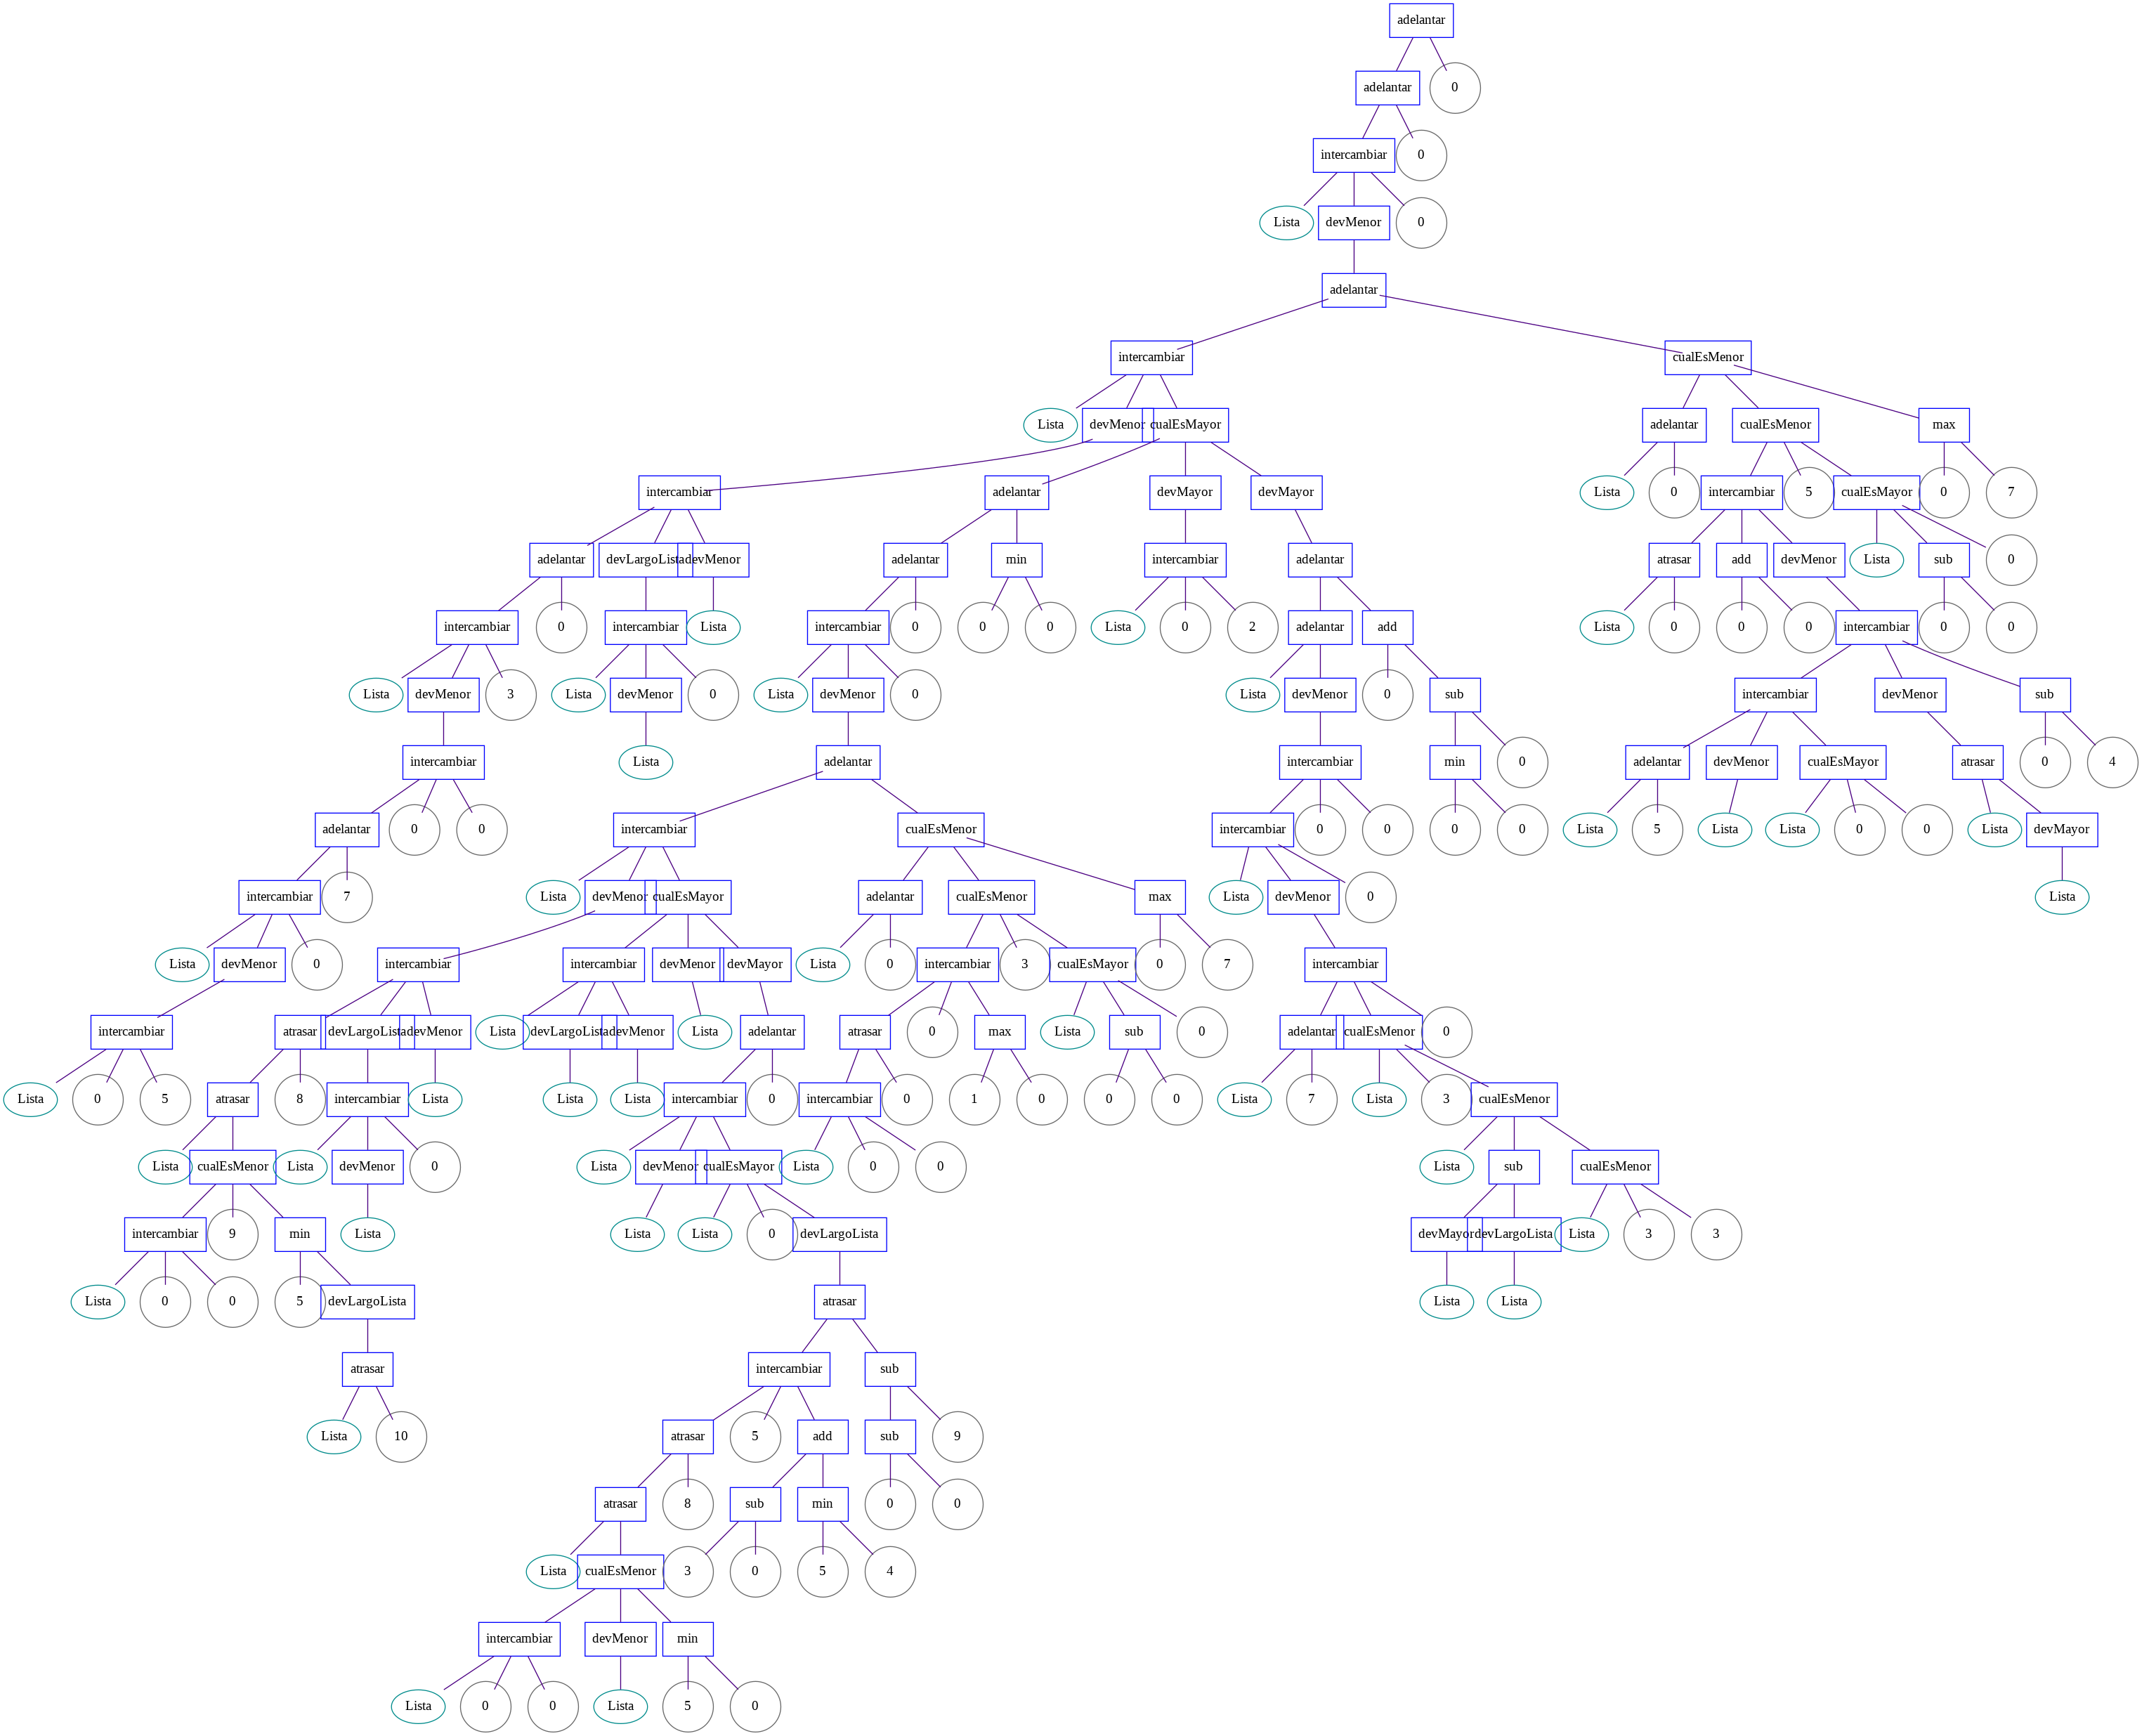





adelantar(adelantar(intercambiar(Lista, devMenor(adelantar(intercambiar(Lista, devMenor(intercambiar(adelantar(intercambiar(Lista, devMenor(intercambiar(adelantar(intercambiar(Lista, devMenor(intercambiar(Lista, 0, 5)), 0), 7), 0, 0)), 3), 0), devLargoLista(intercambiar(Lista, devMenor(Lista), 0)), devMenor(Lista))), cualEsMayor(adelantar(adelantar(intercambiar(Lista, devMenor(adelantar(intercambiar(Lista, devMenor(intercambiar(atrasar(atrasar(Lista, cualEsMenor(intercambiar(Lista, 0, 0), 9, min(5, devLargoLista(atrasar(Lista, 10))))), 8), devLargoLista(intercambiar(Lista, devMenor(Lista), 0)), devMenor(Lista))), cualEsMayor(intercambiar(Lista, devLargoLista(Lista), devMenor(Lista)), devMenor(Lista), devMayor(adelantar(intercambiar(Lista, devMenor(Lista), cualEsMayor(Lista, 0, devLargoLista(atrasar(intercambiar(atrasar(atrasar(Lista, cualEsMenor(intercambiar(Lista, 0, 0), devMenor(Lista), min(5, 0))), 8), 5, add(sub(3, 0), min(5, 4))), sub(sub(0, 0), 9))))), 0)))), cualEsMenor(adel

In [8]:
#@title MOSTRAR GRAFICO DE LA EXPRESIÓN 
## CORRESPONDIENTE AL MEJOR INDIVIDUO 
nodes, edges, labels = gp.graph( ciclosMinIndiv[mejorCiclo] )

g = pgv.AGraph()
g.graph_attr['label']=''
g.node_attr['shape']='box'
g.node_attr['color']='blue'
g.edge_attr['color']='indigo'
g.add_nodes_from(nodes)
g.add_edges_from(edges)
g.layout(prog="dot")

for i in nodes:
    n = g.get_node(i)
    n.attr["label"] = labels[i]
    if labels[i]=='Lista' or labels[i]=='LargoLista':
      n.attr['shape']='oval'
      n.attr['color']='cyan4'
    elif str(labels[i]).isnumeric():
      n.attr['shape']='circle'
      n.attr['color']='dimgray'    

# genera una imagen temporal con el árbol y la muestra
auxFile = tempfile.NamedTemporaryFile(suffix=".png")
g.draw(auxFile.name,format="png")
display(Image.open(auxFile.name))


# Aplica y muesta el resultado
print("\n")
aplicaExpresion(ciclosMinIndiv[mejorCiclo], True)
print("\n")


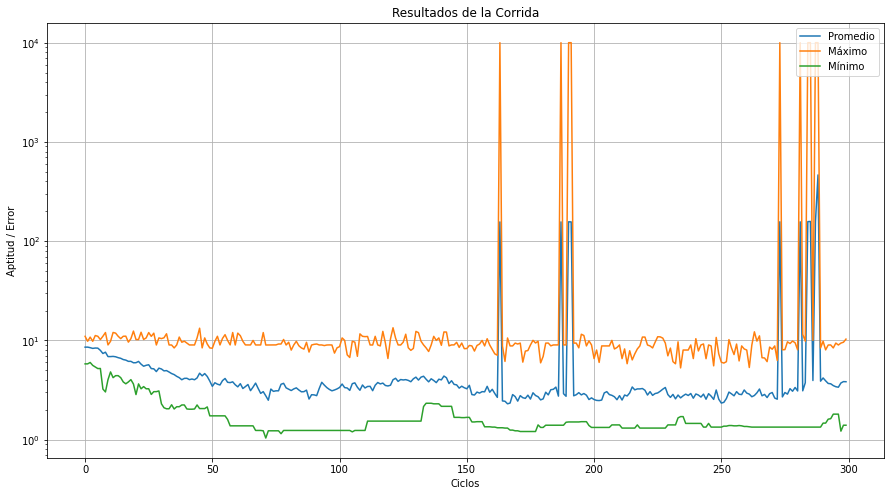

In [9]:
#@title MOSTRAR GRAFICO DE LA CORRIDA
plt.figure(figsize=(15,8)) 
plt.plot(ciclosPromAptitud)
plt.plot(ciclosMaxAptitud)
plt.plot(ciclosMinAptitud)
plt.title('Resultados de la Corrida')
plt.xlabel('Ciclos')
plt.ylabel('Aptitud / Error')
plt.yscale('log')
plt.legend(['Promedio', 'Máximo', 'Mínimo'], loc='upper right')
plt.grid(True)

plt.show()